#  ✅ЗАДАЧА ДАННОГО КОДА
Реализовать и обучить MLP для классификации изображений из набора данных FashionMNIST (https://www.kaggle.com/datasets/zalando-research/fashionmnist), который содержит изображения различных предметов одежды.

# ✅ЧТО ЗДЕСЬ ДЕЛАЕТСЯ И КАК?
Используются библиотеки **torchvision** и **torch**, чтобы загрузить набор данных FashionMNIST.
Данные преобразуются в тензоры с помощью **transforms.ToTensor()**, что позволяет модели обрабатывать изображения.

Загрузчики (DataLoader) создаются для тренировочного и тестового наборов данных. Это упрощает итерацию по данным во время обучения и тестирования.

Создан класс NNModel, который определяет архитектуру нейронной сети:
Сеть состоит из нескольких линейных слоев с функцией активации ReLU и слоями нормализации.
Указан параметр дропаут, чтобы избежать переобучения.
Обработчик входных данных в модели изменён для соответствия размеру изображений 28x28, что эквивалентно 784 (28*28) входам.

Обучение происходит в цикле, который выполняется в течение 1000 эпох.
Используется функция потерь **CrossEntropyLoss** и оптимизатор **Adam** для обновления весов модели.
Каждый батч данных проходит через модель, вычисляется функция потерь, и выполняется обратное распространение ошибок для обновления весов.

In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=ba0d64093cc84a757ad2b350340c3e0bbb3638fc15ec403e0b1f473f1445d5be
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm import tqdm
from torchviz import make_dot
import matplotlib.pyplot as plt

In [3]:
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root = "./data", train = False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 14007926.22it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 314347.81it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2482115.14it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16712288.69it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



✅**КОММЕНТАРИЙ**

В этой ячейке я изменил значение ***shuffle = False*** на ***shuffle = True*** для тренировочного сета, т.к. обычно перемешивание данных во время обучения полезно для предотвращения переобучения. Если это перемешивание нужно отключить, можно оставить ***shuffle=False***.

In [ ]:
# batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
train_item = next(iter(train_loader))
test_item = next(iter(test_loader))
len(train_item), len(test_item), train_item[0].shape, train_item[1].shape

(2, 2, torch.Size([64, 1, 28, 28]), torch.Size([64]))

✅**КОММЕНТАРИЙ**


В списке self.norm переменная inp_size не определена. Правильный индекс должен быть подтянут из layers_size. В данной строке должен использоваться соответствующий индекс при создании слоя нормализации. Поскольку BatchNorm1d применяется к скрытым слоям, правильно указать его для всех, кроме последнего.


---



В self.layers и self.norm создаются списки слоев, но они не добавлены в качестве модуля сети (nn.ModuleList). В PyTorch списки обычных Python объектов не отслеживаются, поэтому модель не будет правильно обучаться или выполняться. Нужно преобразовать их в nn.ModuleList.



---

Параметр dropout_prob = 1.0 означает, что все нейроны будут выключены во время обучения. Обычно значение дропаута варьируется от 0.0 до 0.5. Далее, по коду, мы, кончено, это учтём, но сделаем это сразу внутри класса.

In [11]:
class NNModel(nn.Module):
    def __init__(self,
                 layers_size=[784, 32, 16, 10],  # Изменено с 49 на 784
                 dropout_prob=0.5
                 ):
        super().__init__()

        # Сверточный слой убираем, так как не нужен для MLP
        # self.conv = nn.Conv2d(1, 1, kernel_size=1, stride=1)

        self.layers = nn.ModuleList([nn.Linear(layers_size[i], layers_size[i+1]) for i in range(len(layers_size)-1)])
        # BatchNorm слои для всех, кроме последнего линейного слоя
        self.norm = nn.ModuleList([nn.BatchNorm1d(layers_size[i+1], affine=False) for i in range(len(layers_size)-2)])

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, batch):
        bs = batch.shape[0]
        batch = batch.reshape(bs, -1)

        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                batch = self.dropout(self.relu(self.norm[i](layer(batch))))
            else:
                batch = layer(batch)
        return batch

    def print_net(self):
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                print(layer)
                print(self.norm[i])
                print(self.relu)
                print(self.dropout)
            else:
                print(layer)


✅**КОММЕНТАРИЙ**

Здесь строки закомментированны, т.к. они (судя по их назначению) служат/служили для отладки

In [12]:
mlp  = NNModel(dropout_prob = 0.1)

# predictions = mlp(train_item[0])
# make_dot(predictions, params=dict(mlp.named_parameters()))
mlp.print_net()

Linear(in_features=784, out_features=32, bias=True)
BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=32, out_features=16, bias=True)
BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=16, out_features=10, bias=True)


In [13]:
import torch.optim as optim

✅**КОММЕНТАРИЙ**


В части кода, где выполняется оценка модели (eval part), обратное распространение loss.backward() и шаг оптимизатора optimizer.step() выполняются внутри блока torch.no_grad(). Это неверно, потому что torch.no_grad() отключает вычисление градиентов, и эти операции не должны быть выполнены в режиме оценки.


---

В коде, обучение и оценка модели выполняются только на одном батче данных train_item. В реальных условиях необходимо проходить по всем батчам тренировочного и валидационного датасетов с использованием train_loader и test_loader.



---

Код строит графики потерь, что помогает отслеживать процесс обучения, но можно улучшить его читабельность и добавить подписи к осям.

---

Ещё, тут велезала ошибка, что код ожидает вход размером 49 (что не соответствует изображениям 28x28). Это может быть из-за неправильного использования сверточного слоя или из-за того, что модель не обрабатывает изображения с ожидаемым размером. И я немного поменял архитектуру сети, изменив layers_size

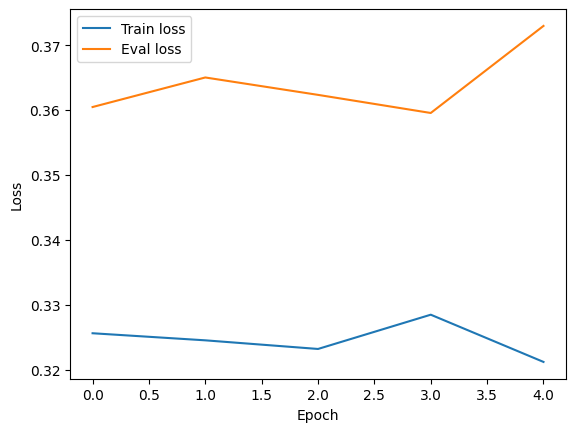

In [15]:
num_epochs = 5 #Поставил 5 эпох чисто убедиться, что этот блок запускается, конечно, этого мало
DEBUG = False

ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.01)


logger = {'train': [], 'eval': []}


for epoch in range(num_epochs):

    epoch_stat = []

    mlp.train()
    for batch in train_loader:
        images, labels = batch
        images, labels = images.float(), labels.long()

        predictions = mlp(images)

        loss = ce_loss(predictions, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_stat.append(loss.item())

    if DEBUG: print(f"train loss value = {np.mean(epoch_stat)}")
    logger['train'].append(np.mean(epoch_stat))

    with torch.no_grad():
        eval_stat = []
        mlp.eval()

        for batch in test_loader:
            images, labels = batch
            images, labels = images.float(), labels.long()

            predictions = mlp(images)
            loss = ce_loss(predictions, labels)

            eval_stat.append(loss.item())

        if DEBUG: print(f"eval loss value = {np.mean(eval_stat)}")
        logger['eval'].append(np.mean(eval_stat))

plt.plot(logger['train'], label='Train loss')
plt.plot(logger['eval'], label='Eval loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
mlp

NNModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
  (norm): ModuleList(
    (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

✅**КОММЕНТАРИЙ**

Здесь строки тоже закомментированны ввиду необязательности их в работе модели (они служат для анализа/отладки)

In [17]:
pytorch_total_params = sum(p.numel() for p in mlp.parameters())
pytorch_total_params

25818